# Aprendizaje Profundo - Práctico 2

Integrantes:


*   Buzzi, Sergio
*   Diaz, Carolina
*   Fabro, Juan

En este notebook, se desarolla el práctico 2. El Objetivo principal de dicho práctico es incorporal un embedding de palabras para aprovechar la variable 'DESCRIPTION'.
Se efectuaron varios experimentos, en los cuales se exploraron distintas configuraciones arquitectónicas de la red final y en particular del dropout, dado que cuando se sube el modelo a la competencia de kaggle el ajuste decae drásticamente, lo que estaría indicando overfitting en train y development.

Como ya conocemos el dataset porque el mismo fue utilizado en una materia previa, no esperamos una accuracy superior al 40 % en el conjunto de test.

A continuación se presenta un modelo en detalle y luego se informa brevemente en otro documento cuales fueron los resultados de los diversos modelos experimentados.


In [1]:
%%bash
pip install --upgrade pip
pip install --upgrade tensorflow-gpu==2.0.0
pip install --upgrade mlflow graphviz pydot

Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (19.3.1)
Requirement already up-to-date: tensorflow-gpu==2.0.0 in /usr/local/lib/python3.6/dist-packages (2.0.0)
Requirement already up-to-date: mlflow in /usr/local/lib/python3.6/dist-packages (1.4.0)
Requirement already up-to-date: graphviz in /usr/local/lib/python3.6/dist-packages (0.13.2)
Requirement already up-to-date: pydot in /usr/local/lib/python3.6/dist-packages (1.4.1)


In [2]:
import nltk
import numpy as np
import os
import pandas as pd
import tensorflow as tf
import time

from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from IPython.display import SVG
from gensim import corpora
from nltk import word_tokenize
from nltk.corpus import stopwords
from pprint import pprint

nltk.download(["punkt", "stopwords"]);

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Carga de los datos

In [0]:
DATA_DIRECTORY = '/content/drive/My Drive/TP2_deeplearning/petfinder_dataset/'

In [5]:
dataset = pd.read_csv(os.path.join(DATA_DIRECTORY, 'train.csv'))

target_col = 'AdoptionSpeed'
nlabels = dataset[target_col].unique().shape[0]

dataset.head(3)

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,Description,AdoptionSpeed,PID
0,2,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,Nibble is a 3+ month old ball of cuteness. He ...,2,0
1,1,4,307,0,2,1,2,0,2,1,1,1,2,1,1,150,41401,"Good guard dog, very alert, active, obedience ...",2,3
2,1,1,307,0,1,1,0,0,2,1,2,2,2,1,1,0,41326,This handsome yet cute boy is up for adoption....,2,4


## Preproceso del texto para agregarlo como feature

### Tokenización

In [0]:
SW = set(stopwords.words("english"))

def tokenize_description(description):
    return [w.lower() for w in word_tokenize(description, language="english") if w.lower() not in SW]

# Fill the null values with the empty string to avoid errors with NLTK tokenization
dataset["TokenizedDescription"] = dataset["Description"].fillna(value="").apply(tokenize_description)

### Detección de tamaño de las descripciones

Un punto importante a tener en cuenta es que las descripciones tienen tamaño variable, y esto no es compatible con los algoritmos de aprendizaje automático. Por lo que hay que llevar las secuencias a un tamaño uniforme.

Para definir dicho tamaño uniforme, es útil mirar qué tamaños mínimos, máximos y medios manejan las descripciones y a partir de esto establecer el tamaño máximo de la secuencia.

In [7]:
pprint(dataset["TokenizedDescription"].apply(len).describe())

count    10582.000000
mean        44.418541
std         48.464623
min          0.000000
25%         16.000000
50%         31.000000
75%         55.000000
max        803.000000
Name: TokenizedDescription, dtype: float64


Vemos que más del 75% de las secuencias tienen 55 palabras o menos. Esto es un buen punto de partida, así que podemos establecer el tamaño máximo de las secuencia en 55 palabras.

In [0]:
MAX_SEQUENCE_LEN = 55

### Vocabulario

In [0]:
vocabulary = corpora.Dictionary(dataset["TokenizedDescription"])
vocabulary.filter_extremes(no_below=1, no_above=1.0, keep_n=10000)

### Word Embeddings (GloVe)

In [11]:
embeddings_index = {}

with open("/content/drive/My Drive/TP2_deeplearning/petfinder_dataset/glove.6B.100d.txt", "r", encoding="utf8") as fh:
    for line in fh:
        values = line.split()
        word = values[0]
        if word in vocabulary.token2id:  # Only use the embeddings of words in our vocabulary
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

print("Found {} word vectors.".format(len(embeddings_index)))

Found 7897 word vectors.


### Creación de los datasets

Similar al práctico anterior, tendremos datos que serán "one-hot-encoded", otros serán "embeddings" y otros serán numéricos.


In [0]:
# It's important to always use the same one-hot length
one_hot_columns = {
    one_hot_col: dataset[one_hot_col].max()
    for one_hot_col in ['Gender', 'Color1','Color2', 'FurLength']
}
embedded_columns = {
    embedded_col: dataset[embedded_col].max() + 1
    for embedded_col in ['Breed1', 'Breed2']
}
numeric_columns = ['Quantity','Age', 'Fee']

## Generador del conjunto de datos

Dada la naturaleza de los datos de texto, y que estos representan una secuencia de datos (que se da luego a una red recurrente o convolucional), en este caso no crearemos los datasets de antemano, sino que los generaremos a medida que el algoritmo de entrenamiento los pida. 

En particular, es porque las secuencias de texto pueden no tener el mismo tamaño (las oraciones tienen diferente cantidad de palabras), pero para que los modelos de redes las acepten, necesitamos rellenarlas (*padding*) de manera que todas tengan el mismo tamaño.

En este paso también vamos a truncar aquellas secuencias de descripciones con más de `MAX_SEQUENCE_LEN` palabras, de manera que al hacer uso de `padded_batch` no lance un error al encontrarse con secuencias de tamaño mayor.

In [13]:
def dataset_generator(ds, test_data=False):
    for _, row in ds.iterrows():
        instance = {}
        
        # One hot encoded features
        instance["direct_features"] = np.hstack([
            tf.keras.utils.to_categorical(row[one_hot_col] - 1, max_value)
            for one_hot_col, max_value in one_hot_columns.items()
        ])

        # Numeric features (should be normalized beforehand)
        # TODO: Add numeric features for row           
        # ya trabajado en el práctico 1 aquí no se lo agrega
        
        # Embedded features
        for embedded_col in embedded_columns:
            instance[embedded_col] = [row[embedded_col]]
        
        # Document to indices for text data, truncated at MAX_SEQUENCE_LEN words
        instance["description"] = vocabulary.doc2idx(
            row["TokenizedDescription"],
            unknown_word_index=len(vocabulary)
        )[:MAX_SEQUENCE_LEN]
        
        # One hot encoded target for categorical crossentropy
        if not test_data:
            target = tf.keras.utils.to_categorical(row[target_col], nlabels)
            yield instance, target
        else:
            yield instance

# Set output types of the generator (for numeric types check the type is valid)
instance_types = {
    "direct_features": tf.float32,
    "description": tf.int32
}

for embedded_col in embedded_columns:
    instance_types[embedded_col] = tf.int32
        
tf_dataset = tf.data.Dataset.from_generator(
    lambda: dataset_generator(dataset),
    output_types=(instance_types, tf.int32)
)

for data, target in tf_dataset.take(2):
    pprint(data)
    pprint(target)
    print()

{'Breed1': <tf.Tensor: id=39, shape=(1,), dtype=int32, numpy=array([299], dtype=int32)>,
 'Breed2': <tf.Tensor: id=40, shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>,
 'description': <tf.Tensor: id=41, shape=(42,), dtype=int32, numpy=
array([23,  2, 20, 24,  4, 10,  1, 11, 26,  1, 27,  9,  6, 21,  3,  8, 15,
       22, 33,  7, 13, 30,  1, 29, 18, 17,  1, 12, 31, 14,  5,  6, 16,  1,
       19, 28, 25, 32, 23,  0,  5,  1], dtype=int32)>,
 'direct_features': <tf.Tensor: id=42, shape=(20,), dtype=float32, numpy=
array([1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0.], dtype=float32)>}
<tf.Tensor: id=43, shape=(5,), dtype=int32, numpy=array([0, 0, 1, 0, 0], dtype=int32)>

{'Breed1': <tf.Tensor: id=44, shape=(1,), dtype=int32, numpy=array([307], dtype=int32)>,
 'Breed2': <tf.Tensor: id=45, shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>,
 'description': <tf.Tensor: id=46, shape=(24,), dtype=int32, numpy=
array([41, 42, 40, 35, 37, 35, 36

## Datos de entrenamiento y validación

Ya generado el conjunto de datos base, tenemos que dividirlo en entrenamiento y validación. Además, como vamos a utilizar algunos datos que forman secuencias, los lotes (*batches*) de datos deben estar "rellenados" (*padded_batch*). 

Si bien rellenaremos "todos" los atributos, en la práctica el único que efectivamente se rellenará es el de *description* pues es el único con tamaños distintos.

In [0]:
TRAIN_SIZE = int(dataset.shape[0] * 0.8)
DEV_SIZE = dataset.shape[0] - TRAIN_SIZE
BATCH_SIZE = 128

shuffled_dataset = tf_dataset.shuffle(TRAIN_SIZE + DEV_SIZE, seed=42)

# Pad the datasets to the max value for all the "non sequence" features
padding_shapes = (
    {k: [-1] for k in ["direct_features"] + list(embedded_columns.keys())},
    [-1]
)

# Pad to MAX_SEQUENCE_LEN for sequence features
padding_shapes[0]["description"] = [MAX_SEQUENCE_LEN]

# Pad values are irrelevant for non padded data
padding_values = (
    {k: 0 for k in list(embedded_columns.keys())},
    0
)

# Padding value for direct features should be a float
padding_values[0]["direct_features"] = np.float32(0)

# Padding value for sequential features is the vocabulary length + 1
padding_values[0]["description"] = len(vocabulary) + 1

train_dataset = shuffled_dataset.skip(DEV_SIZE)\
    .padded_batch(BATCH_SIZE, padded_shapes=padding_shapes, padding_values=padding_values)

dev_dataset = shuffled_dataset.take(DEV_SIZE)\
    .padded_batch(BATCH_SIZE, padded_shapes=padding_shapes, padding_values=padding_values)

## Construyendo el modelo

La diferencia fundamental de esta sección con lo trabajado en el práctico 1 es que aquí se incorpora el embedding de palabras.

### Matriz de embeddings de palabras

In [0]:
EMBEDDINGS_DIM = 100  # Given by the model (in this case glove.6B.100d)

embedding_matrix = np.zeros((len(vocabulary) + 2, 100))

for widx, word in vocabulary.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[widx] = embedding_vector
    else:
        # Random normal initialization for words without embeddings
        embedding_matrix[widx] = np.random.normal(size=(100,))  

# Random normal initialization for unknown words
embedding_matrix[len(vocabulary)] = np.random.normal(size=(100,))

### Definiendo los inputs del modelo

Definamos los inputs del modelo, con el agregado de la capa de embeddings de palabras inicializada en `embedding_matrix`.

In [16]:
tf.keras.backend.clear_session()

# Add one input and one embedding for each embedded column
embedding_layers = []
inputs = []
for embedded_col, max_value in embedded_columns.items():
    input_layer = tf.keras.layers.Input(shape=(1,), name=embedded_col)
    inputs.append(input_layer)
    # Define the embedding layer
    embedding_size = int(max_value / 4)
    embedding_layers.append(
        tf.squeeze(
            tf.keras.layers.Embedding(
                input_dim=max_value, 
                output_dim=embedding_size
            )(input_layer), 
            axis=-2
        )
    )
    print('Adding embedding of size {} for layer {}'.format(embedding_size, embedded_col))

# Add the direct features already calculated
direct_features_input = tf.keras.layers.Input(
    shape=(sum(one_hot_columns.values()),), 
    name='direct_features'
)
inputs.append(direct_features_input)

# Word embedding layer
description_input = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LEN,), name="description")
inputs.append(description_input)

word_embeddings_layer = tf.keras.layers.Embedding(
    embedding_matrix.shape[0],
    EMBEDDINGS_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LEN,
    trainable=False,
    name="word_embedding"
)(description_input)

Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2


### Definiendo la red que trabajará con el texto

Antes de generar el *feature map* final entre los inputs y las clases, tenemos que generar el *feature map* de las secuencias de texto. 

Para ello pueden utilizar una red neuronal recurrente o convolucional.

Pueden pensar dicha red como un submodelo del modelo general que se encarga de generar los atributos que representan la descripción de la mascota (recordemos que las redes se utilizan para hacer aprendizaje de representaciones).

La red puede ser tan compleja como ustedes lo consideren pertinente.

In [134]:
## TODO: Create a NN (CNN or RNN) for the description input (replace the next) 
#DONE!!!!!!!!!!!!!!!!!!!!!

FILTER_WIDTHS = [2, 3, 5, 10]  # Take 2, 3, 5 & 10 words
FILTER_COUNT = 64

sequence_input = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LEN,), dtype='int64', name="input")

# The embedding layer is initialized with our embedding_matrix and is not trainable
embeddings_layer = tf.keras.layers.Embedding(
    embedding_matrix.shape[0],
    EMBEDDINGS_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LEN,
    trainable=False,
    name="word_embedding"
)

embedded_sequences = embeddings_layer(sequence_input)

conv_layers = []
for filter_width in FILTER_WIDTHS:
    layer = tf.keras.layers.Conv1D(
        FILTER_COUNT,
        filter_width,
        activation="relu",
        name="conv_{}_words".format(filter_width)
    )(embedded_sequences)
    layer = tf.keras.layers.GlobalMaxPooling1D(name="max_pool_{}_words".format(filter_width))(layer)
    conv_layers.append(layer)

convolved_features = tf.keras.layers.Concatenate(name="convolved_features")(conv_layers)
output = tf.keras.layers.Dense(1, activation="sigmoid", name="output")(convolved_features)
model = tf.keras.models.Model(inputs=[sequence_input], outputs=[output], name="Red convolucional para texto")

model.compile(
    optimizer="nadam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

#DESCRIPTION_FEATURES_LAYER_SIZE = 256
#DESCRIPTION_FEATURES_LAYER_SIZE = 512
DESCRIPTION_FEATURES_LAYER_SIZE = 1024

description_features = tf.keras.layers.Flatten()(word_embeddings_layer)  # This is a simple concatenation
description_features = tf.keras.layers.Dense(units=DESCRIPTION_FEATURES_LAYER_SIZE, 
                                             activation="relu", name="description_features")(description_features)

Model: "Red convolucional para texto"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 55)]         0                                            
__________________________________________________________________________________________________
word_embedding (Embedding)      (None, 55, 100)      1000200     input[0][0]                      
__________________________________________________________________________________________________
conv_2_words (Conv1D)           (None, 54, 64)       12864       word_embedding[0][0]             
__________________________________________________________________________________________________
conv_3_words (Conv1D)           (None, 53, 64)       19264       word_embedding[0][0]             
_______________________________________________________________________

### Definiendo el *feature map* final de la red

Ahora que tenemos nuestra representación de las descripciones, pasamos a combinarlo con los demás features en la última parte de nuestra red. Solo se muestra el modelo seleccionado luego de realizar varias pruebas.Se introducen varios dropout para reducir el sobreajuste.

In [0]:
#HIDDEN_LAYER_SIZE = 128
#HIDDEN_LAYER_SIZE = 256
HIDDEN_LAYER_SIZE = 512

#DROPOUT_RATE = 0.5
DROPOUT_RATE = 0.75


feature_map = tf.keras.layers.Concatenate(name="feature_map")(
    embedding_layers + [description_features, direct_features_input]
)

dense1 = layers.Dense(HIDDEN_LAYER_SIZE, activation='relu')(feature_map)

drop1 = layers.Dropout(DROPOUT_RATE)(dense1)

dense2 = layers.Dense(HIDDEN_LAYER_SIZE / 2, activation='relu')(drop1)

drop2 = layers.Dropout(DROPOUT_RATE)(dense2)

dense3 = layers.Dense(HIDDEN_LAYER_SIZE / 4, activation='relu')(drop2)

output_layer = layers.Dense(nlabels, activation='softmax')(dense3)

model = models.Model(inputs=inputs, outputs=output_layer, name="modelo_buenazo")


### Compilando y visualizando el modelo

In [185]:
model.compile(loss='categorical_crossentropy', 
              optimizer='nadam',
              metrics=['accuracy'])
model.summary()

Model: "modelo_buenazo"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
description (InputLayer)        [(None, 55)]         0                                            
__________________________________________________________________________________________________
Breed1 (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
Breed2 (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
word_embedding (Embedding)      (None, 55, 100)      1000200     description[0][0]                
_____________________________________________________________________________________

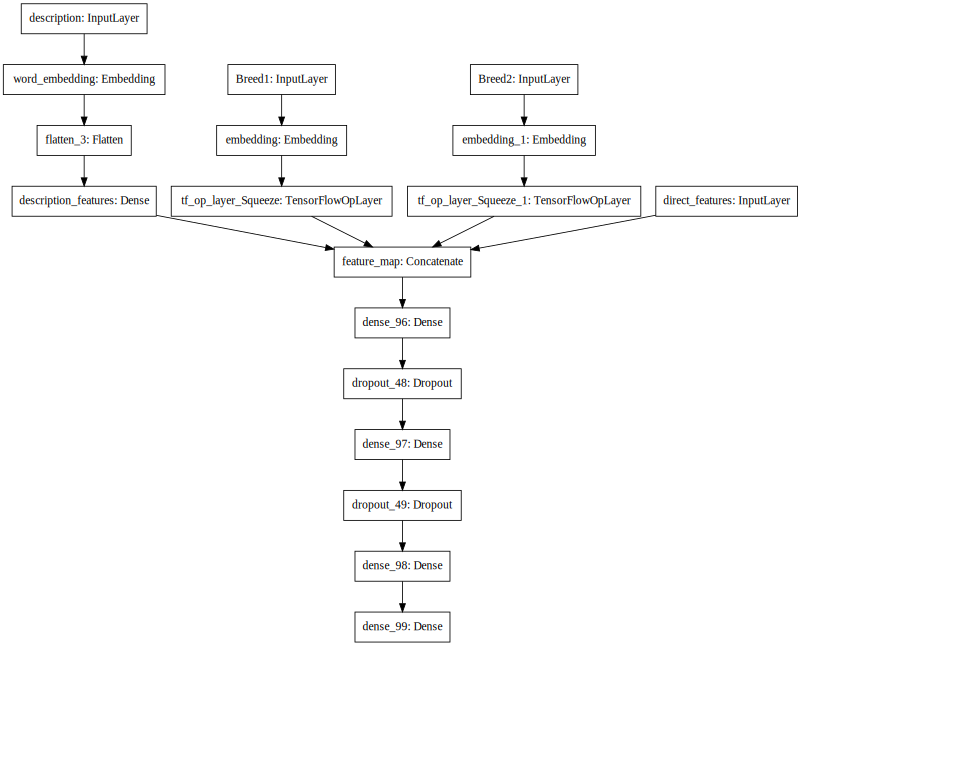

In [186]:
SVG(tf.keras.utils.model_to_dot(model, dpi=60).create(prog='dot', format='svg'))

## Entrenando el modelo

Para entrenar el modelo es igual al caso anterior, ya generados el conjunto de datos correspondiente. Lo entrenamos con ayuda de `mlflow`.

In [187]:
import mlflow
import mlflow.keras

mlflow.set_experiment('modelo_buenazo')

with mlflow.start_run(nested=True):
    # Log model hiperparameters first
    mlflow.log_param('description_features_layer_size', DESCRIPTION_FEATURES_LAYER_SIZE)
    mlflow.log_param('hidden_layer_size', HIDDEN_LAYER_SIZE)
    mlflow.log_param('embedded_columns', embedded_columns)
    mlflow.log_param('one_hot_columns', one_hot_columns)
    # mlflow.log_param('numerical_columns', numerical_columns)  # Not using these yet
    
    # Train
    epochs = 10
    history = model.fit(train_dataset, epochs=epochs)
    
    # Evaluate
    loss, accuracy = model.evaluate(dev_dataset, verbose=0)
    print("\n*** Validation loss: {} - accuracy: {}".format(loss, accuracy))
    mlflow.log_metric('epochs', epochs)
    mlflow.log_metric('train_loss', history.history["loss"][-1])
    mlflow.log_metric('train_accuracy', history.history["accuracy"][-1])
    mlflow.log_metric('validation_loss', loss)
    mlflow.log_metric('validation_accuracy', accuracy)

    model1 =mlflow.log_metric('validation_loss', loss)
    mlflow.log_metric('validation_accuracy', accuracy)
    mlflow.keras.log_model(model, 'models')

Epoch 1/10
67/67 [==============================] - 8s 123ms/step - loss: 1.4533 - accuracy: 0.4430
Epoch 2/10
67/67 [==============================] - 7s 103ms/step - loss: 0.5730 - accuracy: 0.8117
Epoch 3/10
67/67 [==============================] - 6s 96ms/step - loss: 0.3037 - accuracy: 0.9062
Epoch 4/10
67/67 [==============================] - 7s 97ms/step - loss: 0.2419 - accuracy: 0.9320
Epoch 5/10
67/67 [==============================] - 7s 98ms/step - loss: 0.1715 - accuracy: 0.9460
Epoch 6/10
67/67 [==============================] - 6s 96ms/step - loss: 0.1746 - accuracy: 0.9523
Epoch 7/10
67/67 [==============================] - 6s 97ms/step - loss: 0.1428 - accuracy: 0.9556
Epoch 8/10
67/67 [==============================] - 6s 97ms/step - loss: 0.1360 - accuracy: 0.9605
Epoch 9/10
67/67 [==============================] - 7s 97ms/step - loss: 0.1305 - accuracy: 0.9610
Epoch 10/10
67/67 [==============================] - 7s 98ms/step - loss: 0.1262 - accuracy: 0.9626

*** Va

Es intrigante notar que sobreajusta bastante (en test accuracy= 0.38) aún cuando se introdujeron varios dropouts y se está usando una probabilidad de dropeo relativamente elevada (0.50). Como conocemos de antemano este dataset, sabemos que es difícil obtener un accuracy superior al 40% en el conjunto de datos de test.

## Evaluando el modelo sobre los datos de evaluación para la competencia

Comenzamos cargando el conjunto de datos.

In [180]:
test_dataset = pd.read_csv(os.path.join(DATA_DIRECTORY, 'test.csv'))
test_dataset.head()

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,Description,PID
0,2,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,I just found it alone yesterday near my apartm...,1
1,1,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,41326,Their pregnant mother was dumped by her irresp...,2
2,1,0,307,0,2,1,2,7,2,1,2,2,2,1,6,0,41326,Siu Pak just give birth on 13/6/10 to 6puppies...,7
3,2,12,265,0,2,1,7,0,2,2,3,3,3,1,1,0,41326,"Very manja and gentle stray cat found, we woul...",9
4,2,3,264,0,2,1,2,5,3,3,1,1,2,1,1,50,41326,Kali is a super playful kitten who is on the g...,11


## Creamos el conjunto de datos para darle al modelo entrenado


In [181]:
# First tokenize the description

test_dataset["TokenizedDescription"] = test_dataset["Description"]\
    .fillna(value="").apply(tokenize_description)

# Generate the basic TF dataset

tf_test_dataset = tf.data.Dataset.from_generator(
    lambda: dataset_generator(test_dataset, True),
    output_types=instance_types  # It should have the same instance types
)

for data in tf_test_dataset.take(2):  # The dataset only returns a data instance now (no target)
    pprint(data)
    print()

{'Breed1': <tf.Tensor: id=89676, shape=(1,), dtype=int32, numpy=array([265], dtype=int32)>,
 'Breed2': <tf.Tensor: id=89677, shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>,
 'description': <tf.Tensor: id=89678, shape=(13,), dtype=int32, numpy=
array([ 116,  429, 1371,  991,  189,    1, 7873, 1043,   62,  600,  728,
          5,    1], dtype=int32)>,
 'direct_features': <tf.Tensor: id=89679, shape=(20,), dtype=float32, numpy=
array([1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0.], dtype=float32)>}

{'Breed1': <tf.Tensor: id=89680, shape=(1,), dtype=int32, numpy=array([307], dtype=int32)>,
 'Breed2': <tf.Tensor: id=89681, shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>,
 'description': <tf.Tensor: id=89682, shape=(47,), dtype=int32, numpy=
array([ 945,  154,  256, 2049,  105,  403,  991, 4677,  552,  545,    1,
        142,  134,  403,    1,  118,  210,   73,    1,  533,  387,   35,
        394,  272,   98,   62,    1,  464,  411,  

## Padding batches

Por último, y previo a probar el modelo sobre los datos de evaluación, generamos el conjunto de datos "rellenado". 


In [0]:
test_data = tf_test_dataset.padded_batch(
    BATCH_SIZE, 
    padded_shapes=padding_shapes[0], 
    padding_values=padding_values[0]
)

## Correr el modelo

El último paso es correr el modelo sobre los datos de evaluación para conseguir las predicciones a enviar a la competencia.

In [0]:
test_dataset["AdoptionSpeed"] = model.predict(test_data).argmax(axis=1)

test_dataset.to_csv("./submission.csv", index=False, columns=["PID", "AdoptionSpeed"])